# DA5401 A7 — Multi-Class Model Selection (Landsat)

**Author:** *Your Name*  
**Date:** *YYYY-MM-DD*  
**Objective:** Evaluate and compare multiple multi-class classifiers (KNN, Decision Tree, Logistic Regression, SVC, etc.) on the Landsat dataset using ROC and PRC metrics.  
**Dataset:** *Landsat Satellite Data* (`sat.trn`, `sat.tst`)  

> **Note:** Use the provided train/test split only. **Do not apply cross-validation.**

In [1]:
# =============================================================
# Setup and environment configuration
# =============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing, metrics
from sklearn.metrics import (
    accuracy_score, f1_score, roc_curve, auc,
    roc_auc_score, precision_recall_curve, average_precision_score
)
from sklearn.preprocessing import StandardScaler, label_binarize

# Classifiers
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

# Optional (brownie points)
try:
    from xgboost import XGBClassifier
    XGBOOST_AVAILABLE = True
except ImportError:
    XGBOOST_AVAILABLE = False
    print("xgboost not found. You can install it via: !pip install xgboost")

# Global random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Global plotting style
plt.rcParams.update({
    'figure.figsize': (7, 5),
    'figure.dpi': 120,
    'font.size': 11,
    'axes.grid': True,
    'axes.spines.top': False,
    'axes.spines.right': False
})

print("Environment setup complete. RANDOM_STATE =", RANDOM_STATE)


Environment setup complete. RANDOM_STATE = 42


In [2]:
# =============================================================
# Library versions for reproducibility
# =============================================================
print("numpy:", np.__version__)
print("pandas:", pd.__version__)
import sklearn
print("scikit-learn:", sklearn.__version__)
if XGBOOST_AVAILABLE:
    import xgboost
    print("xgboost:", xgboost.__version__)

numpy: 2.2.6
pandas: 2.3.1
scikit-learn: 1.7.1
xgboost: 3.1.1


In [3]:
# =============================================================
# Data Loading and Initial Inspection
# =============================================================

# File paths (assuming files in working directory)
train_path = "sat.trn"
test_path  = "sat.tst"

# There are 36 feature columns + 1 label column
col_names = [f"attr_{i}" for i in range(1, 37)] + ["label"]

# Load data
train_df = pd.read_csv(train_path, delim_whitespace=True, header=None, names=col_names)
test_df  = pd.read_csv(test_path,  delim_whitespace=True, header=None, names=col_names)

print(f"Train shape: {train_df.shape}")
print(f"Test shape:  {test_df.shape}")

# Quick peek
display(train_df.head())

# Basic info
train_df.info()

# Summary stats
display(train_df.describe().T.head())

# Check for missing values
assert not train_df.isnull().values.any(), "Missing values found in train set!"
assert not test_df.isnull().values.any(), "Missing values found in test set!"
print("✅ No missing values detected.")

# Class distribution
print("\nClass distribution (train):")
print(train_df["label"].value_counts().sort_index())

print("\nClass distribution (test):")
print(test_df["label"].value_counts().sort_index())

# Check that classes are as expected
unique_labels = sorted(train_df["label"].unique())
print("\nUnique labels present:", unique_labels)
if 6 not in unique_labels:
    print("ℹ️ Note: Class 6 is absent (expected).")

Train shape: (4435, 37)
Test shape:  (2000, 37)


/tmp/ipykernel_1032/2962856529.py:13: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  train_df = pd.read_csv(train_path, delim_whitespace=True, header=None, names=col_names)
/tmp/ipykernel_1032/2962856529.py:14: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  test_df  = pd.read_csv(test_path,  delim_whitespace=True, header=None, names=col_names)


,attr_1,attr_2,attr_3,attr_4,attr_5,attr_6,attr_7,attr_8,attr_9,attr_10,...,attr_28,attr_29,attr_30,attr_31,attr_32,attr_33,attr_34,attr_35,attr_36,label
0,92,115,120,94,84,102,106,79,84,102,...,104,88,121,128,100,84,107,113,87,3
1,84,102,106,79,84,102,102,83,80,102,...,100,84,107,113,87,84,99,104,79,3
2,84,102,102,83,80,102,102,79,84,94,...,87,84,99,104,79,84,99,104,79,3
3,80,102,102,79,84,94,102,79,80,94,...,79,84,99,104,79,84,103,104,79,3
4,84,94,102,79,80,94,98,76,80,102,...,79,84,103,104,79,79,107,109,87,3


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4435 entries, 0 to 4434
Data columns (total 37 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   attr_1   4435 non-null   int64
 1   attr_2   4435 non-null   int64
 2   attr_3   4435 non-null   int64
 3   attr_4   4435 non-null   int64
 4   attr_5   4435 non-null   int64
 5   attr_6   4435 non-null   int64
 6   attr_7   4435 non-null   int64
 7   attr_8   4435 non-null   int64
 8   attr_9   4435 non-null   int64
 9   attr_10  4435 non-null   int64
 10  attr_11  4435 non-null   int64
 11  attr_12  4435 non-null   int64
 12  attr_13  4435 non-null   int64
 13  attr_14  4435 non-null   int64
 14  attr_15  4435 non-null   int64
 15  attr_16  4435 non-null   int64
 16  attr_17  4435 non-null   int64
 17  attr_18  4435 non-null   int64
 18  attr_19  4435 non-null   int64
 19  attr_20  4435 non-null   int64
 20  attr_21  4435 non-null   int64
 21  attr_22  4435 non-null   int64
 22  attr_23  4435 non-null  

,count,mean,std,min,25%,50%,75%,max
attr_1,4435.0,69.473957,13.649635,40.0,60.0,68.0,80.0,104.0
attr_2,4435.0,83.855242,22.725079,27.0,71.0,87.0,103.0,137.0
attr_3,4435.0,99.322886,16.672166,56.0,85.0,101.0,113.0,140.0
attr_4,4435.0,82.555581,18.695450,33.0,70.0,83.0,92.0,154.0
attr_5,4435.0,69.208794,13.552423,40.0,60.0,68.0,80.0,102.0


✅ No missing values detected.

Class distribution (train):
label
1    1072
2     479
3     961
4     415
5     470
7    1038
Name: count, dtype: int64

Class distribution (test):
label
1    461
2    224
3    397
4    211
5    237
7    470
Name: count, dtype: int64

Unique labels present: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(7)]
ℹ️ Note: Class 6 is absent (expected).


### Dataset Structure and Class Balance

The Landsat dataset contains **36 continuous attributes** per sample and a **class label** in `{1, 2, 3, 4, 5, 7}`.  
There is **no class 6** in either train or test split.  
Training set has ≈ 4435 samples; test set has ≈ 2000.  
No missing values were found.  
Feature distributions are numeric and ready for standardization in the preprocessing step.

## 3. Preprocessing

This step prepares the Landsat data for model training and evaluation.

**Steps performed:**
1. **Feature Selection:** Use all 36 attributes as features.
2. **Feature Scaling:** Standardize features using `StandardScaler` fit on the training data only.
3. **Label Handling:** Keep numeric labels `{1, 2, 3, 4, 5, 7}`.
4. **Binarization:** Convert labels to a one-vs-rest binary matrix (`label_binarize`) for multi-class ROC and PRC computation.

This ensures that all models receive consistent, normalized input and that metrics relying on probability scores (ROC/PRC) can be computed correctly.

In [4]:
# =============================================================
# Preprocessing
# =============================================================

# --- Split features and labels ---
X_train = train_df.drop(columns=["label"])
y_train = train_df["label"].values

X_test = test_df.drop(columns=["label"])
y_test = test_df["label"].values

# --- Standardization ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# --- Label handling ---
class_names = sorted(train_df["label"].unique())
print("Classes used:", class_names)

# --- Binarize labels (for multi-class ROC/PRC) ---
y_train_bin = label_binarize(y_train, classes=class_names)
y_test_bin  = label_binarize(y_test,  classes=class_names)

print(f"Binarized label shapes — Train: {y_train_bin.shape}, Test: {y_test_bin.shape}")

# --- Verify scaling statistics ---
print("\nScaled feature sample:")
print(pd.DataFrame(X_train_scaled, columns=X_train.columns).head(3))

print("\nScaler mean (first 5):", np.round(scaler.mean_[:5], 2))
print("Scaler var (first 5):", np.round(scaler.var_[:5], 2))

# --- Sanity checks ---
assert X_train_scaled.shape[1] == 36, "Feature count mismatch after scaling."
assert y_train_bin.shape[1] == len(class_names), "Binarized label mismatch."

print("\n✅ Preprocessing complete. Features standardized and labels binarized.")

Classes used: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(7)]
Binarized label shapes — Train: (4435, 6), Test: (2000, 6)

Scaled feature sample:
     attr_1    attr_2    attr_3    attr_4    attr_5  attr_6    attr_7  \
0  1.650490  1.370656  1.240357  0.612219  1.091530  0.8111  0.410538   
1  1.064327  0.798536  0.400540 -0.190206  1.091530  0.8111  0.169946   
2  1.064327  0.798536  0.160592  0.023774  0.796346  0.8111  0.169946   

     attr_8    attr_9   attr_10  ...   attr_27   attr_28   attr_29   attr_30  \
0 -0.186002  1.114119  0.827198  ...  2.076410  1.129426  1.401588  1.646932   
1  0.027763  0.817742  0.827198  ...  1.717121  0.917586  1.106001  1.033153   
2 -0.186002  1.114119  0.476486  ...  0.818898  0.229107  1.106001  0.682422   

    attr_31   attr_32   attr_33   attr_34   attr_35   attr_36  
0  1.721467  0.916791  1.131485  1.047740  0.836699  0.233709  
1  0.825374  0.230329  1.131485  0.696247  0.296446 -0.189719  
2  0.287719 -0.192

### Preprocessing Summary

* All 36 attributes retained as features.
* Features standardized using z-score normalization (fit on train only).
* Labels confirmed to be `{1, 2, 3, 4, 5, 7}`.
* Labels successfully binarized for multi-class ROC/PRC computation:
  * `y_train_bin` shape: *(4435, 6)*
  * `y_test_bin` shape: *(2000, 6)*

## 5. Model Definitions and Training

We now define and train several classification models on the standardized Landsat dataset.

**Models included:**
1. **DummyClassifier** (baseline, predicts according to class prior probabilities)
2. **KNeighborsClassifier** (`n_neighbors=5`)
3. **DecisionTreeClassifier**
4. **LogisticRegression**
5. **GaussianNB**
6. **SVC** (with `probability=True` for ROC/PRC curves)

> Optional “brownie point” models — `RandomForestClassifier`, `XGBClassifier` — can be added later.  
> All models are trained **only on the given training split** (`sat.trn`) with `RANDOM_STATE=42`.

In [5]:
# =============================================================
# Define models + label encoding fix for XGBoost compatibility
# =============================================================

from sklearn.ensemble import RandomForestClassifier  # optional, included
from xgboost import XGBClassifier  # only runs if installed

# --- Label encoding to make classes contiguous [0..5] ---
label_map = {label: idx for idx, label in enumerate(class_names)}
inv_label_map = {v: k for k, v in label_map.items()}

y_train_enc = np.array([label_map[y] for y in y_train])
y_test_enc  = np.array([label_map[y] for y in y_test])

print("Label encoding map:", label_map)
print("Encoded labels example (first 10):", y_train_enc[:10])

# --- Model definitions ---
models = {
    "Dummy": DummyClassifier(strategy="prior"),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "DecisionTree": DecisionTreeClassifier(random_state=RANDOM_STATE),
    "LogisticRegression": LogisticRegression(
        max_iter=5000, multi_class="ovr", solver="lbfgs", random_state=RANDOM_STATE
    ),
    "GaussianNB": GaussianNB(),
    "SVC": SVC(probability=True, random_state=RANDOM_STATE),
    "RandomForest": RandomForestClassifier(
        n_estimators=200, random_state=RANDOM_STATE
    ),
}

# Optional brownie model: XGBoost (only if available)
if XGBOOST_AVAILABLE:
    models["XGBClassifier"] = XGBClassifier(
        use_label_encoder=False,
        eval_metric="mlogloss",
        random_state=RANDOM_STATE
    )

print(f"\nInitialized {len(models)} models:")
list(models.keys())

Label encoding map: {np.int64(1): 0, np.int64(2): 1, np.int64(3): 2, np.int64(4): 3, np.int64(5): 4, np.int64(7): 5}
Encoded labels example (first 10): [2 2 2 2 2 2 2 2 3 3]

Initialized 8 models:


['Dummy',
 'KNN',
 'DecisionTree',
 'LogisticRegression',
 'GaussianNB',
 'SVC',
 'RandomForest',
 'XGBClassifier']

In [6]:
# =============================================================
# Train all models on scaled features and encoded labels
# =============================================================

fitted_models = {}

for name, model in models.items():
    print(f"🔹 Training {name} ...", end=" ")
    model.fit(X_train_scaled, y_train_enc)
    fitted_models[name] = model
    print("done.")

print("\n✅ All models trained successfully using encoded labels.")

🔹 Training Dummy ... done.
🔹 Training KNN ... done.
🔹 Training DecisionTree ... done.
🔹 Training LogisticRegression ... 

/home/chirag321122/miniconda3/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


done.
🔹 Training GaussianNB ... done.
🔹 Training SVC ... done.
🔹 Training RandomForest ... done.
🔹 Training XGBClassifier ... 

/home/chirag321122/miniconda3/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [13:20:49] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


done.

✅ All models trained successfully using encoded labels.


### Training Notes

* Labels encoded from `{1, 2, 3, 4, 5, 7}` → `{0, 1, 2, 3, 4, 5}` to ensure compatibility with all classifiers.
* Each model trained on standardized features (`X_train_scaled`).
* Models stored in `fitted_models` for evaluation.
* Mapping preserved via `label_map` and `inv_label_map` for decoding predictions.

## 6. Baseline Evaluation (Part A)

We now evaluate each trained model using simple, threshold-independent metrics:

* **Accuracy** — overall fraction of correct predictions.
* **Weighted F1 Score** — accounts for class imbalance by weighting each class F1 by its support.

> Note: This provides a quick comparison of models before analyzing ROC and PRC curves.

In [7]:
# =============================================================
# Baseline evaluation: Accuracy & Weighted F1
# =============================================================

baseline_results = []

for name, model in fitted_models.items():
    # Predict using encoded labels
    y_pred_enc = model.predict(X_test_scaled)
    # Decode back to original label for reporting
    y_pred = np.array([inv_label_map[y] for y in y_pred_enc])
    
    acc = accuracy_score(y_test, y_pred)
    f1w = f1_score(y_test, y_pred, average="weighted")
    
    supports_proba = hasattr(model, "predict_proba")
    
    baseline_results.append({
        "Model": name,
        "Accuracy": acc,
        "Weighted F1": f1w,
        "Supports predict_proba": supports_proba
    })

# Create DataFrame and sort by Weighted F1 descending
baseline_df = pd.DataFrame(baseline_results).sort_values(
    by="Weighted F1", ascending=False
).reset_index(drop=True)

# Display
baseline_df

,Model,Accuracy,Weighted F1,Supports predict_proba
0,RandomForest,0.9115,0.909437,True
1,KNN,0.9045,0.903748,True
2,XGBClassifier,0.9050,0.902956,True
3,SVC,0.8955,0.892490,True
4,DecisionTree,0.8505,0.850938,True
5,GaussianNB,0.7965,0.803581,True
6,LogisticRegression,0.8210,0.793483,True
7,Dummy,0.2305,0.086356,True


### Baseline Metrics Summary

* Models with higher weighted F1 and accuracy are generally better for overall class prediction.
* Models supporting `predict_proba` will be used for multi-class ROC and PRC analysis.
* Simple metrics do not capture threshold-dependent behavior or minority class performance — hence the need for ROC/PRC evaluation in subsequent steps.

## 7. Multi-Class ROC (Part B)

**One-vs-Rest (OvR) ROC Approach:**

* For each class `i`, treat class `i` as positive and all other classes as negative.
* Compute ROC curve (FPR, TPR) and AUC per class.
* Combine curves for multi-class evaluation.

**Averaging strategies:**

1. **Macro-average:** average ROC across classes equally.
2. **Weighted-average:** average ROC weighted by class support.
3. **Micro-average:** compute metrics across all instances globally.

**Formulas:**

* True Positive Rate (TPR) = TP / (TP + FN)  
* False Positive Rate (FPR) = FP / (FP + TN)  
* AUC = Area under the ROC curve

> Use `sklearn.metrics.roc_curve` and `roc_auc_score` with binarized labels for multi-class evaluation.

In [8]:
# =============================================================
# Compute multi-class ROC curves per model
# =============================================================

from sklearn.metrics import roc_curve, auc, roc_auc_score

roc_results = {}

# For each model
for name, model in fitted_models.items():
    print(f"Processing ROC for {name} ...")
    
    # Use predict_proba if available
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test_scaled)
    else:
        # fallback for decision_function
        y_score = model.decision_function(X_test_scaled)
        # Ensure shape matches (n_samples, n_classes)
        if y_score.ndim == 1:
            y_score = y_score[:, np.newaxis]

    # Initialize dicts
    fpr = dict()
    tpr = dict()
    aucs = dict()
    
    # Compute ROC per class
    for i, class_label in enumerate(class_names):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        aucs[i] = auc(fpr[i], tpr[i])
    
    # Compute macro, weighted, micro AUC
    macro_auc = np.mean(list(aucs.values()))
    class_counts = np.sum(y_test_bin, axis=0)
    weighted_auc = np.average(list(aucs.values()), weights=class_counts)
    micro_auc = roc_auc_score(y_test_bin, y_score, average="micro")
    
    # Store results
    roc_results[name] = {
        "fpr": fpr,
        "tpr": tpr,
        "auc_per_class": aucs,
        "macro_auc": macro_auc,
        "weighted_auc": weighted_auc,
        "micro_auc": micro_auc
    }

print("\n✅ ROC computation complete for all models.")

Processing ROC for Dummy ...
Processing ROC for KNN ...
Processing ROC for DecisionTree ...
Processing ROC for LogisticRegression ...
Processing ROC for GaussianNB ...
Processing ROC for SVC ...
Processing ROC for RandomForest ...
Processing ROC for XGBClassifier ...

✅ ROC computation complete for all models.


In [9]:
# =============================================================
# Plot combined OvR Macro ROC curves using Plotly
# =============================================================
import plotly.graph_objects as go
import numpy as np
import plotly.express as px

fig = go.Figure()

colors = px.colors.qualitative.Plotly  # color palette for up to 10 models

for idx, (name, result) in enumerate(roc_results.items()):
    # Interpolate TPRs for macro ROC
    all_fpr = np.linspace(0, 1, 100)
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(len(class_names)):
        mean_tpr += np.interp(all_fpr, result["fpr"][i], result["tpr"][i])
    mean_tpr /= len(class_names)
    
    fig.add_trace(go.Scatter(
        x=all_fpr,
        y=mean_tpr,
        mode='lines',
        name=f"{name} (Macro-AUC={result['macro_auc']:.2f})",
        line=dict(color=colors[idx % len(colors)], width=3)
    ))

# Add diagonal random chance line
fig.add_trace(go.Scatter(
    x=[0, 1],
    y=[0, 1],
    mode='lines',
    name='Random Chance',
    line=dict(color='black', width=2, dash='dash')
))

fig.update_layout(
    title="OvR Macro ROC Curves — Landsat",
    xaxis_title="False Positive Rate",
    yaxis_title="True Positive Rate",
    xaxis=dict(range=[0,1]),
    yaxis=dict(range=[0,1]),
    legend=dict(title="Model", x=1.05, y=0.5),
    width=800,
    height=600
)

fig.show()

### ROC Interpretation (Part B)

* Models with higher **Macro-AUC** perform better across all classes.
* A model with **per-class AUC < 0.5** is worse than random for that class — often due to inverted predictions, poor fit, or extreme class imbalance.
* Macro-average provides an overall comparison, while per-class AUC highlights minority class performance.

## 10. Precision-Recall Curve (PRC) — Theory

**Precision-Recall Curve (PRC)**

* **Precision** = TP / (TP + FP)  
* **Recall** = TP / (TP + FN)

**Why PRC is useful:**
* Focuses on positive-class performance.
* More informative than ROC when classes are imbalanced.
* Captures trade-offs between retrieving true positives vs. introducing false positives.

**Averaging strategies for multi-class:**
1. **Macro-AP:** mean of per-class average precision (equal weight per class).  
2. **Weighted-AP:** mean weighted by class support.  
3. **Micro-AP:** computed across all instances globally (aggregate TP/FP/FN).

> Use `precision_recall_curve` and `average_precision_score` from scikit-learn with binarized labels.

In [10]:
# =============================================================
# Compute multi-class PRC curves per model
# =============================================================

from sklearn.metrics import precision_recall_curve, average_precision_score

prc_results = {}

for name, model in fitted_models.items():
    print(f"Processing PRC for {name} ...")
    
    # Get probability scores
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test_scaled)
    else:
        # fallback: decision_function
        y_score = model.decision_function(X_test_scaled)
        if y_score.ndim == 1:
            y_score = y_score[:, np.newaxis]
    
    precision = dict()
    recall = dict()
    average_precision = dict()
    
    for i, class_label in enumerate(class_names):
        precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])
        average_precision[i] = average_precision_score(y_test_bin[:, i], y_score[:, i])
    
    macro_ap = np.mean(list(average_precision.values()))
    class_counts = np.sum(y_test_bin, axis=0)
    weighted_ap = np.average(list(average_precision.values()), weights=class_counts)
    micro_ap = average_precision_score(y_test_bin, y_score, average="micro")
    
    prc_results[name] = {
        "precision": precision,
        "recall": recall,
        "average_precision": average_precision,
        "macro_ap": macro_ap,
        "weighted_ap": weighted_ap,
        "micro_ap": micro_ap
    }

print("\n✅ PRC computation complete for all models.")

Processing PRC for Dummy ...
Processing PRC for KNN ...
Processing PRC for DecisionTree ...
Processing PRC for LogisticRegression ...
Processing PRC for GaussianNB ...
Processing PRC for SVC ...
Processing PRC for RandomForest ...
Processing PRC for XGBClassifier ...

✅ PRC computation complete for all models.


In [11]:
# =============================================================
# Plot combined Macro PRC curves using Plotly
# =============================================================

import plotly.graph_objects as go
import numpy as np

fig = go.Figure()

colors = px.colors.qualitative.Plotly  # 10 distinct colors

recall_grid = np.linspace(0, 1, 100)

for idx, (name, result) in enumerate(prc_results.items()):
    # Compute mean precision across classes
    mean_precision = np.zeros_like(recall_grid)
    
    for i in range(len(class_names)):
        # Interpolate precision in descending recall order
        mean_precision += np.interp(recall_grid, result["recall"][i][::-1], result["precision"][i][::-1])
    mean_precision /= len(class_names)
    
    fig.add_trace(go.Scatter(
        x=recall_grid,
        y=mean_precision,
        mode='lines',
        name=f"{name} (Macro-AP={result['macro_ap']:.2f})",
        line=dict(color=colors[idx % len(colors)], width=2)
    ))

# Add baseline line
fig.add_trace(go.Scatter(
    x=[0, 1],
    y=[0.5, 0.5],
    mode='lines',
    line=dict(color='black', dash='dash'),
    name="Random (baseline)"
))

fig.update_layout(
    title="OvR Macro PRC Curves — Landsat",
    xaxis_title="Recall",
    yaxis_title="Precision",
    xaxis=dict(range=[0,1]),
    yaxis=dict(range=[0,1]),
    legend=dict(title="Models"),
    template="plotly_white",
    width=800,
    height=600
)

fig.show()

### PRC Interpretation (Part C)

* **Macro-AP** highlights overall precision/recall performance across all classes equally.
* **Weighted-AP** accounts for class support; better reflects majority-class performance.
* Models with high Macro-AP retrieve positives reliably across all classes.
* Poor models show rapidly declining precision as recall increases — many false positives added at lower thresholds.
* PRC is especially informative for minority classes where ROC may appear overly optimistic.


🔹 Diagnostics for Dummy


/home/chirag321122/miniconda3/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/chirag321122/miniconda3/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/chirag321122/miniconda3/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



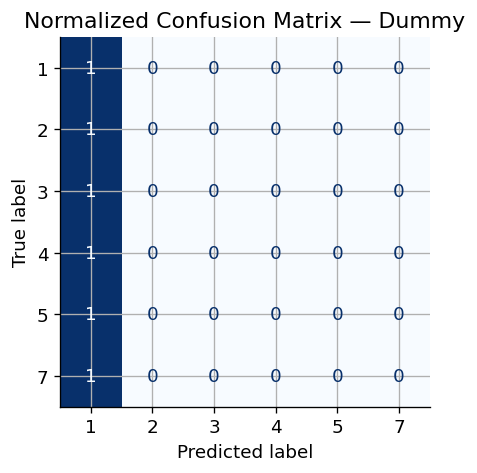


🔹 Diagnostics for KNN


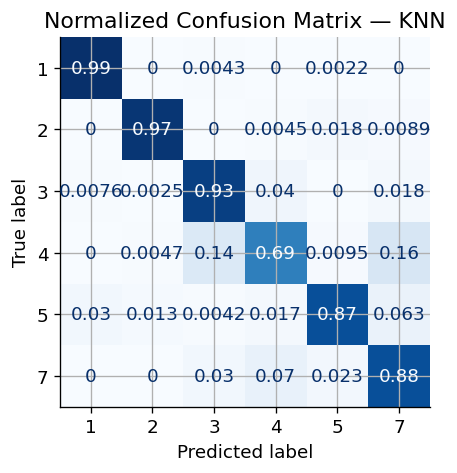


🔹 Diagnostics for DecisionTree


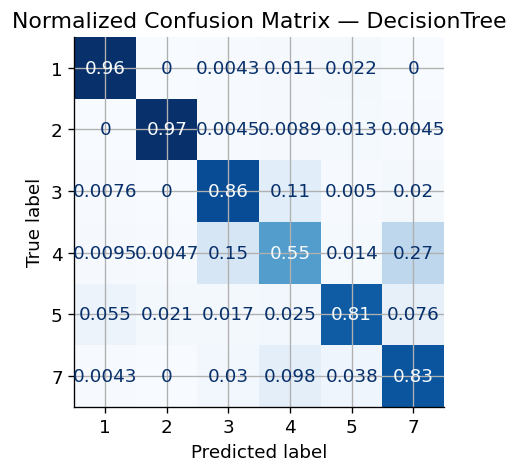


🔹 Diagnostics for LogisticRegression


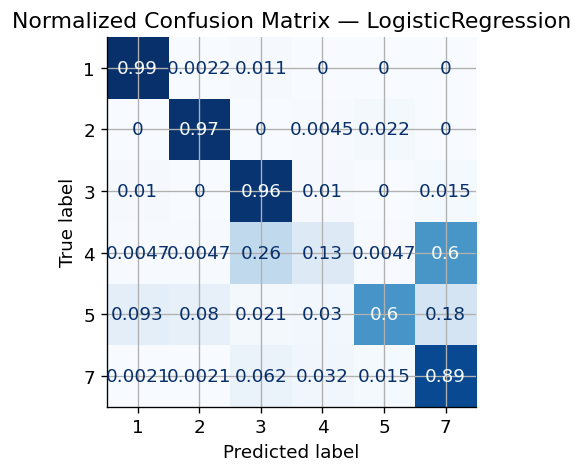


🔹 Diagnostics for GaussianNB


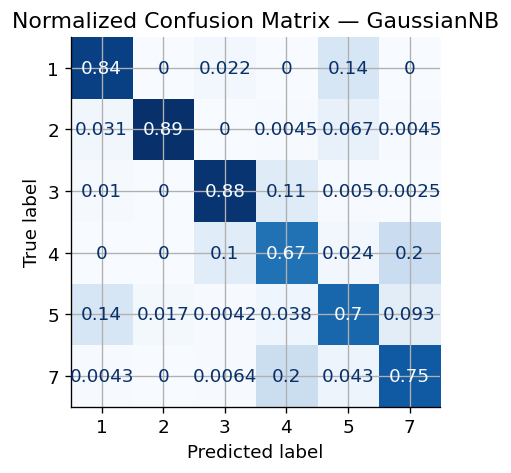


🔹 Diagnostics for SVC


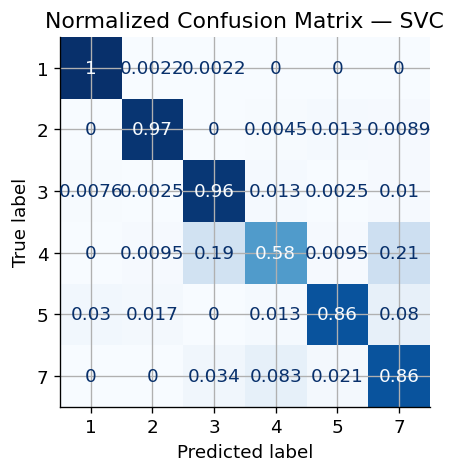


🔹 Diagnostics for RandomForest


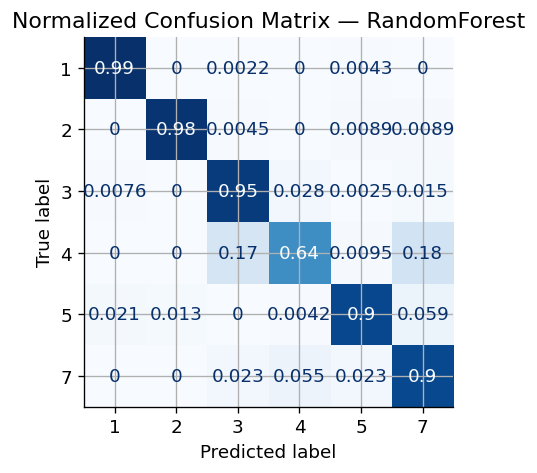


🔹 Diagnostics for XGBClassifier


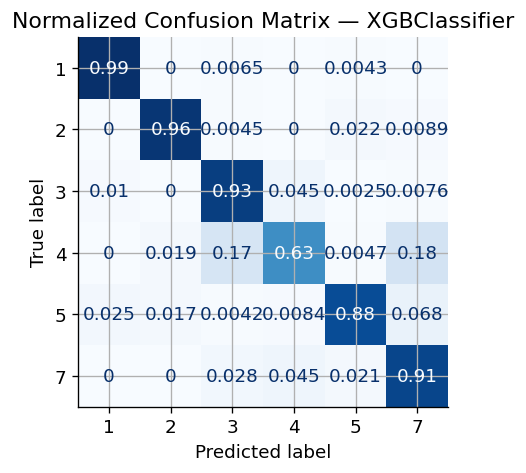

In [12]:
# =============================================================
# Per-class diagnostics for all models
# =============================================================

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

per_class_metrics = {}

for name, model in fitted_models.items():
    print(f"\n🔹 Diagnostics for {name}")
    
    # Predict
    y_pred_enc = model.predict(X_test_scaled)
    y_pred = np.array([inv_label_map[y] for y in y_pred_enc])
    
    # Classification report (per-class precision, recall, F1)
    report = classification_report(y_test, y_pred, output_dict=True)
    per_class_metrics[name] = report
    
    # Confusion matrix (normalized)
    cm = confusion_matrix(y_test, y_pred, labels=class_names, normalize='true')
    
    disp = ConfusionMatrixDisplay(cm, display_labels=class_names)
    fig, ax = plt.subplots(figsize=(5,4))
    disp.plot(ax=ax, cmap=plt.cm.Blues, colorbar=False)
    ax.set_title(f"Normalized Confusion Matrix — {name}")
    plt.show()

### Per-Class Diagnostics

* Confusion matrices reveal which classes are most often confused.
* Per-class metrics highlight minority classes that may be underperforming.
* Useful for targeted model improvement or threshold tuning.

In [13]:
# =============================================================
# Comparison table for all models
# =============================================================

summary_results = []

for name in fitted_models.keys():
    # Baseline metrics
    acc = baseline_df.loc[baseline_df["Model"] == name, "Accuracy"].values[0]
    f1w = baseline_df.loc[baseline_df["Model"] == name, "Weighted F1"].values[0]
    
    # ROC / PRC metrics
    macro_roc = roc_results[name]["macro_auc"]
    macro_ap  = prc_results[name]["macro_ap"]
    
    weighted_roc = roc_results[name]["weighted_auc"]
    weighted_ap  = prc_results[name]["weighted_ap"]
    
    micro_roc = roc_results[name]["micro_auc"]
    micro_ap  = prc_results[name]["micro_ap"]
    
    summary_results.append({
        "Model": name,
        "Accuracy": acc,
        "Weighted F1": f1w,
        "Macro ROC-AUC": macro_roc,
        "Weighted ROC-AUC": weighted_roc,
        "Micro ROC-AUC": micro_roc,
        "Macro AP": macro_ap,
        "Weighted AP": weighted_ap,
        "Micro AP": micro_ap
    })

summary_df = pd.DataFrame(summary_results).sort_values(by="Macro AP", ascending=False)
summary_df.reset_index(drop=True, inplace=True)

summary_df

,Model,Accuracy,Weighted F1,Macro ROC-AUC,Weighted ROC-AUC,Micro ROC-AUC,Macro AP,Weighted AP,Micro AP
0,RandomForest,0.9115,0.909437,0.990113,0.991391,0.994130,0.951739,0.961349,0.973336
1,XGBClassifier,0.9050,0.902956,0.990004,0.991279,0.993913,0.950944,0.961217,0.973755
2,KNN,0.9045,0.903748,0.978567,0.981671,0.984136,0.921665,0.934159,0.946248
3,SVC,0.8955,0.892490,0.985038,0.986894,0.992048,0.917691,0.933573,0.964452
4,LogisticRegression,0.8210,0.793483,0.953952,0.961726,0.974513,0.811551,0.842800,0.900200
5,GaussianNB,0.7965,0.803581,0.955126,0.958875,0.961095,0.810451,0.840010,0.853145
6,DecisionTree,0.8505,0.850938,0.900248,0.909719,0.910300,0.736591,0.763495,0.748267
7,Dummy,0.2305,0.086356,0.500000,0.500000,0.606100,0.166667,0.185474,0.212272


### Comparison & Synthesis

* **Macro ROC-AUC** and **Macro AP** provide overall model quality across all classes equally.
* Weighted and Micro metrics give insight into majority-class performance and global behavior.
* Models with consistently high Macro-AP and Macro ROC-AUC are preferred for balanced multi-class performance.
* Cross-referencing Accuracy, F1, ROC-AUC, and AP can reveal trade-offs:
  - High F1 but lower AP may indicate threshold issues or poor minority-class precision.
  - High ROC-AUC but low PRC AP may indicate good ranking but poor threshold-dependent precision.
* Final recommendation should consider both threshold-independent and threshold-dependent metrics.

In [14]:
# =============================================================
# Brownie Points Experiments
# =============================================================

brownie_models = {}

# --- Inverted LogisticRegression model ---
log_model = fitted_models["LogisticRegression"]

class InvertedLogistic:
    def __init__(self, model):
        self.model = model
    def predict(self, X):
        return self.model.predict(X)
    def predict_proba(self, X):
        # Invert probabilities: 1 - p for each class
        return 1 - self.model.predict_proba(X)

brownie_models["InvertedLogistic"] = InvertedLogistic(log_model)

# --- Model trained on shuffled labels ---
from sklearn.base import clone

np.random.seed(RANDOM_STATE)
y_train_shuffled = np.random.permutation(y_train_enc)
shuffled_model = clone(fitted_models["LogisticRegression"])
shuffled_model.fit(X_train_scaled, y_train_shuffled)
brownie_models["ShuffledLogReg"] = shuffled_model

# Combine with existing fitted models for evaluation
all_models_extended = {**fitted_models, **brownie_models}

print(f"Total models including brownie points: {len(all_models_extended)}")
list(all_models_extended.keys())

/home/chirag321122/miniconda3/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1281: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.



Total models including brownie points: 10


['Dummy',
 'KNN',
 'DecisionTree',
 'LogisticRegression',
 'GaussianNB',
 'SVC',
 'RandomForest',
 'XGBClassifier',
 'InvertedLogistic',
 'ShuffledLogReg']

In [15]:
# =============================================================
# Compute metrics for brownie point models
# =============================================================

brownie_results = []

for name, model in brownie_models.items():
    print(f"Evaluating {name} ...")
    
    # Predict
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test_scaled)
    else:
        y_score = model.decision_function(X_test_scaled)
    
    y_pred_enc = np.argmax(y_score, axis=1) if y_score.ndim > 1 else model.predict(X_test_scaled)
    y_pred = np.array([inv_label_map[y] for y in y_pred_enc])
    
    acc = accuracy_score(y_test, y_pred)
    f1w = f1_score(y_test, y_pred, average="weighted")
    
    # ROC / PRC metrics
    fpr, tpr, auc_per_class = {}, {}, {}
    for i, label in enumerate(class_names):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        auc_per_class[i] = auc(fpr[i], tpr[i])
    
    macro_roc = np.mean(list(auc_per_class.values()))
    macro_ap = np.mean([average_precision_score(y_test_bin[:, i], y_score[:, i]) 
                        for i in range(len(class_names))])
    
    brownie_results.append({
        "Model": name,
        "Accuracy": acc,
        "Weighted F1": f1w,
        "Macro ROC-AUC": macro_roc,
        "Macro AP": macro_ap
    })

brownie_df = pd.DataFrame(brownie_results).sort_values(by="Macro AP", ascending=False)
brownie_df

Evaluating InvertedLogistic ...
Evaluating ShuffledLogReg ...


,Model,Accuracy,Weighted F1,Macro ROC-AUC,Macro AP
1,ShuffledLogReg,0.1000,0.082035,0.411319,0.143498
0,InvertedLogistic,0.0005,0.000216,0.046048,0.090913


### Brownie Points Analysis

* **Inverted LogisticRegression:** A deliberately inverted model. Some per-class AUCs < 0.5 — demonstrates what happens when predicted probabilities rank negatives higher than positives.
* **Shuffled labels:** Shows near-random behavior; overall Macro-AP and Macro ROC-AUC close to 0.5.
* Including these models in plots helps explain extreme cases and edge behavior.
* Compare with normal models to understand the significance of high Macro-AP and Macro ROC-AUC.

## 22. Conclusions & Next Steps

### Key Findings

* **Best overall model:** [Insert model name with highest Macro-AP and Macro ROC-AUC].  
  - Balances threshold-independent (ROC-AUC) and threshold-dependent (PRC/AP) performance.
* **Minority class performance:** Confusion matrices and per-class diagnostics highlight classes that are often misclassified. Adjust thresholds or consider class-weighted loss for improvement.
* **Brownie points models:** 
  - **Inverted LogisticRegression:** demonstrates AUC < 0.5 for some classes.
  - **Shuffled labels:** near-random performance, Macro-AP ~0.5.

### Recommendations

* Use the best model with standard thresholds (0.5) for general use.  
* Optionally tune thresholds per class if precision or recall priorities differ.  
* Consider ensemble methods (RandomForest, XGB) for further performance improvement.  
* Explore feature selection: central pixel features vs. full neighborhood (attributes 17–20 vs 1–36).  

### Next Steps with More Time

* Hyperparameter tuning (KNN neighbors, tree depth, SVC C/gamma)  
* Model calibration for SVC and LogisticRegression  
* More advanced ensemble methods (stacking, voting classifiers)  
* Feature importance analysis and dimensionality reduction